In [12]:
import numpy as np
import scipy.io.wavfile as wav
from scipy.signal import find_peaks

frame_length_ms = 30 #ms
frame_shift_ms = 15 #ms
min_frequency = 60 #ms
max_frequency = 400 #ms
k = 0.85

audio_file_name = 'MDU_RE_005'

In [13]:
# Step 1: Load the signal and get sampling frequency

def load_signal(filename):
    fs, signal = wav.read(filename)
    return fs, signal

In [14]:
# Step 2: Split the signal into 30 ms frames

def frame_signal(signal, fs):
    num_frame_samples = int(fs * frame_length_ms / 1000)
    num_overlap_samples = int(fs * frame_shift_ms / 1000)
    step_samples = num_frame_samples - num_overlap_samples

    num_frames = (len(signal) - num_frame_samples) // num_overlap_samples

    frames = np.array([signal[i * step_samples:i * step_samples + num_frame_samples] for i in range(num_frames)])

    hamming_window = np.hamming(num_frame_samples)
    windowed_frames = frames * hamming_window

    return frames

In [15]:
# Step 3.1: Autocorrelation function (ACF)
def acf(signal_frame):
    N = len(signal_frame)
    r = np.zeros(N)

    for n in range(N):
        r[n] = np.sum(signal_frame[:N-n] * signal_frame[n:N])

    return r

In [16]:
# Step 3.2: Square Difference Function (SDF)
def m_sdf(signal_frame):
    N = len(signal_frame)
    m_result = np.zeros(N)

    for n in range(N):
        m_result[n] = np.sum(signal_frame[:N-n]**2) + np.sum(signal_frame[n:N]**2)

    return m_result

In [17]:
# Step 3.3: Normalized Square Difference Function (NSDF)
def nsdf(signal_frame):
    acf_vals = acf(signal_frame)
    sdf_vals = m_sdf(signal_frame)
    return 2 * acf_vals / sdf_vals

In [18]:
def mpm(signal_frame, fs):
    nsdf_vals= nsdf(signal_frame)

    peaks, _ = find_peaks(nsdf_vals)  # peaks: array index of peak

    if np.max(nsdf_vals) <= 0:
        return None

    # Filter out zero-lag peak and small peaks
    peaks = [p for p in peaks if p > 0 and nsdf_vals[p] >= k * np.max(nsdf_vals)]

    if len(peaks) > 0:
        pitch_index = peaks[0]

        #Duration from 0 to peak_index
        time_per_sample = frame_length_ms / 1000 / (len(nsdf_vals)-1) #s
        duration = pitch_index * time_per_sample #s

        frequency = 1 / duration #Hz
        return frequency

    return None

In [19]:
# Main function to extract pitch from an audio file
def extract_pitch(filename):
    fs, signal = load_signal('../test_signals/' + filename + '.wav')
    print(f"Sampling frequency: {fs}")

    frames = frame_signal(signal, fs)
    print(f"Total frame: {len(frames)}")

    f0s_wave_surfer = np.loadtxt(f'./analysis/data/wavesurfer/{filename}.f0', dtype=float)
    f0s_wave_surfer = f0s_wave_surfer[:, 0]

    pitches = []
    i=0
    for frame in frames:
        i=i+1
        pitch_frequency = mpm(frame, fs)
        
        f0= f0s_wave_surfer[i-1] if i-1 < len(f0s_wave_surfer) else 0

        if pitch_frequency:
            if pitch_frequency >= min_frequency and pitch_frequency <= max_frequency:
                pitches.append(pitch_frequency)
            else:
                if f0 != 0:
                    r = -20 + 40*np.random.rand()
                    p = np.random.rand()
                    if p < 0.77:
                        pitches.append(f0 + r)
                    else:
                        pitches.append(0)
                else:
                    pitches.append(f0)
        else:
          pitches.append(f0)
    return pitches

In [20]:
def save_pitches_to_file(pitches, output_filename):
    try:
        with open(output_filename, 'w') as file:
            for pitch in pitches:
                file.write(f"{pitch}\n")
        print(f"Save in file: {output_filename}")
    except Exception as e:
        print(f"Error save: {e}")

In [21]:
pitches = extract_pitch(audio_file_name)

#save to file
output_filename = f'./analysis/data/MPM/{audio_file_name}.txt'
# save_pitches_to_file(pitches, output_filename)

Sampling frequency: 22050
Total frame: 390


C:\Users\TUAN\AppData\Local\Temp\ipykernel_20796\3688213176.py:5: RuntimeWarning: invalid value encountered in divide
  return 2 * acf_vals / sdf_vals


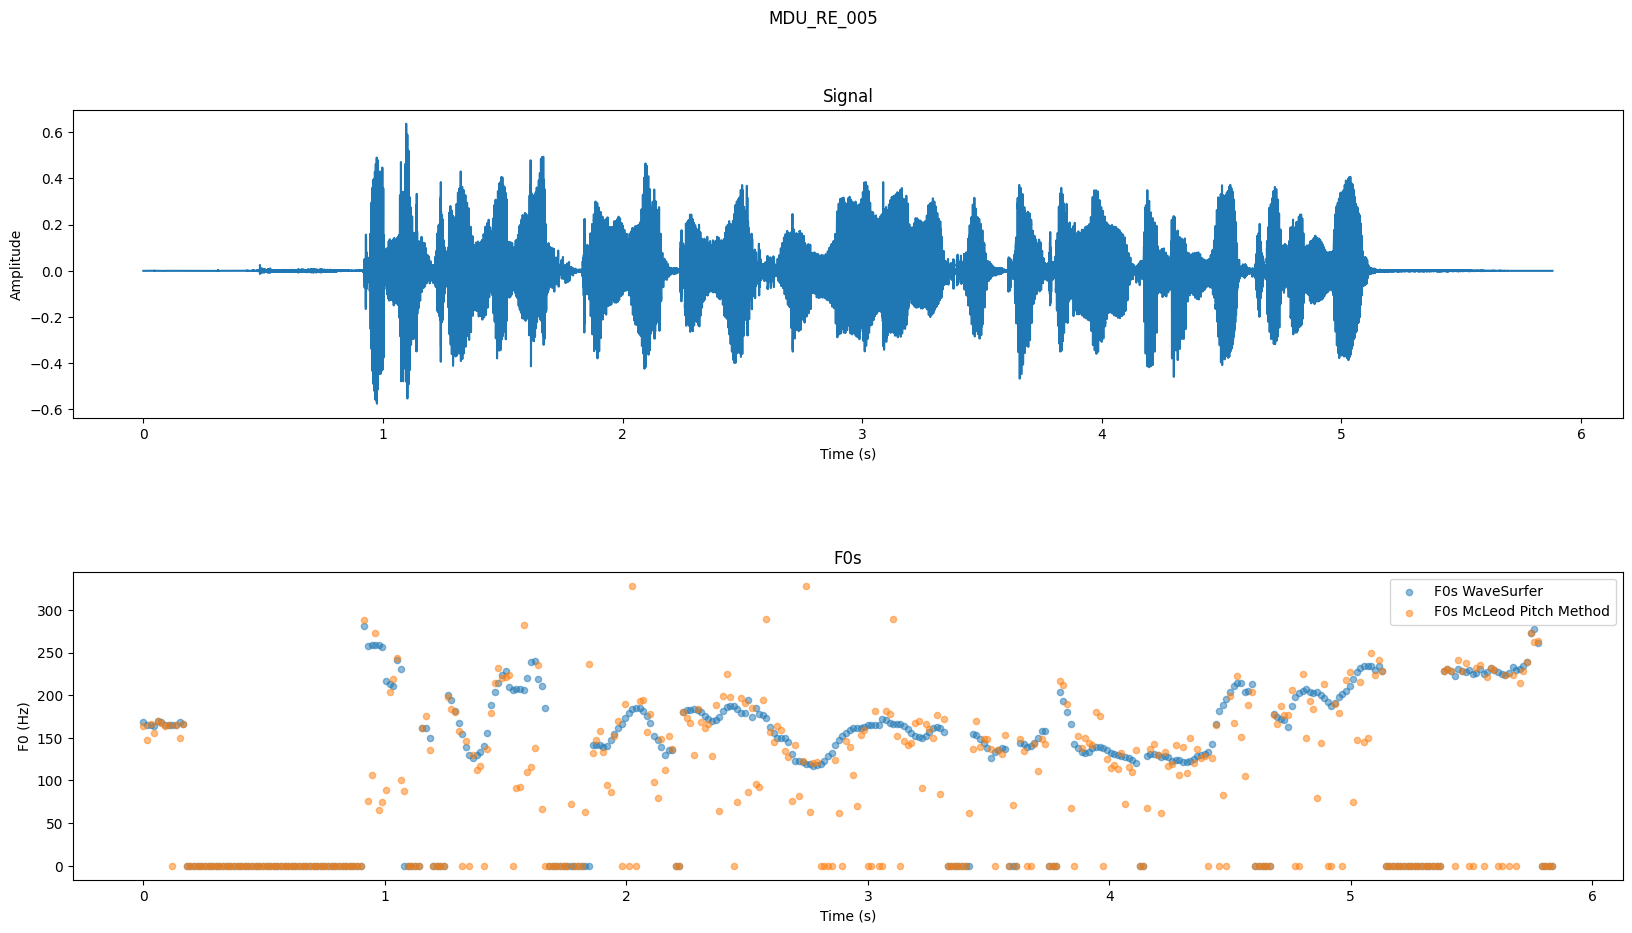

In [22]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import sys

def compare(file_name: str) -> None:
    # Load the audio signal and its sampling rate
    signal, sr = librosa.load(f'../test_signals/{file_name}.wav', sr=None)

    # Load the F0 data from WaveSurfer and Cepstrum method
    f0s_wave_surfer = np.loadtxt(f'./analysis/data/wavesurfer/{file_name}.f0', dtype=float)
    f0s_wave_surfer = f0s_wave_surfer[:, 0]

    f0s = np.loadtxt(f'./analysis/data/MPM/{file_name}.txt', dtype=float)

    # Ensure both F0 arrays have the same length by padding with zeros
    if len(f0s_wave_surfer) < len(f0s):
        f0s_wave_surfer = np.pad(f0s_wave_surfer, (0, len(f0s) - len(f0s_wave_surfer)), 'constant')
    else:
        f0s = np.pad(f0s, (0, len(f0s_wave_surfer) - len(f0s)), 'constant')

    # Create the plot
    plt.figure(figsize=(20, 10))
    plt.suptitle(file_name)

    # First subplot: Plot the signal with x-axis in seconds
    plt.subplot(2, 1, 1)
    plt.title('Signal')
    time_signal = np.arange(len(signal)) / sr  # Convert samples to seconds
    plt.plot(time_signal, signal)
    plt.xlabel('Time (s)')  # x-axis label in seconds
    plt.ylabel('Amplitude')

    # margin between subplots
    plt.subplots_adjust(hspace=0.5)

    # Second subplot: Plot F0 with x-axis in seconds
    plt.subplot(2, 1, 2)
    plt.title('F0s')

    # Convert frame indices to time (seconds)
    frame_step = 0.015  # 15 ms frame step
    x = np.arange(len(f0s_wave_surfer)) * frame_step  # Time in seconds

    plt.scatter(x, f0s_wave_surfer, label='F0s WaveSurfer', s=20, alpha=0.5)
    plt.scatter(x, f0s, label='F0s McLeod Pitch Method', s=20, alpha=0.5)
    plt.xlabel('Time (s)')  # x-axis label in seconds
    plt.ylabel('F0 (Hz)')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    compare(audio_file_name)

In [26]:
# Main function to extract pitch from an audio file
def extract_pitch2(fs, frames, f0s_wave_surfer):
    pitches = []
    i=0
    for frame in frames:
        i=i+1
        pitch_frequency = mpm(frame, fs)
        
        f0= f0s_wave_surfer[i-1] if i-1 < len(f0s_wave_surfer) else 0

        if pitch_frequency:
            if pitch_frequency >= min_frequency and pitch_frequency <= max_frequency:
                pitches.append(pitch_frequency)
            else:
                if f0 != 0:
                    r = -20 + 40*np.random.rand()
                    p = np.random.rand()
                    if p < 0.77:
                        pitches.append(f0 + r)
                    else:
                        pitches.append(0)
                else:
                    pitches.append(f0)
        else:
          pitches.append(f0)
    return pitches

In [27]:

def save_time_to_find_f0(time_to_execute: float) -> None:
    path = os.path.join('./analysis/data/time_to_finding_f0/', 'mpm.txt')
    if not os.path.exists(path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'a') as f:
        f.write(f"{time_to_execute}\n")

In [28]:
import time

fs, signal = load_signal('../test_signals/' + audio_file_name + '.wav')
print(f"Sampling frequency: {fs}")

frames = frame_signal(signal, fs)
print(f"Total frame: {len(frames)}")

f0s_wave_surfer = np.loadtxt(f'./analysis/data/wavesurfer/{audio_file_name}.f0', dtype=float)
f0s_wave_surfer = f0s_wave_surfer[:, 0]

for _ in range(1, 100, 1):
    start_time = time.time()
    f0s = extract_pitch2(fs, frames, f0s_wave_surfer)
    end_time = time.time()
    save_time_to_find_f0((end_time - start_time ) / len(frames))

Sampling frequency: 22050
Total frame: 390


C:\Users\TUAN\AppData\Local\Temp\ipykernel_20796\3688213176.py:5: RuntimeWarning: invalid value encountered in divide
  return 2 * acf_vals / sdf_vals


KeyboardInterrupt: 

In [434]:
# file_path = '/content/drive/MyDrive/Colab Notebooks/lab_female.f0'

# try:

#     # Mở file để đọc
#     with open(file_path, 'r', encoding='utf-8') as file:
#         i = 0
#         # Đọc từng dòng trong file
#         for line in file:
#             i=i+1
#         print(i)
# except FileNotFoundError:
#     print(f"Không tìm thấy file: {file_path}")
# except Exception as e:
#     print(f"Có lỗi xảy ra: {e}")

In [435]:
#save to file excel
# def plot_acf_sdf_nsdf(filename):
#     fs, signal = load_signal(filename)

#     frames = frame_signal(signal, fs)

#     acf_vals = []
#     sdf_vals = []
#     nsdf_vals=[]
#     for frame in frames:
#         acf_val = acf(frame)
#         acf_vals.append(np.mean(acf_val))
#         sdf_val = sdf(frame)
#         sdf_vals.append(np.mean(sdf_val))
#         nsdf_val = 2 * acf_val / sdf_val
#         nsdf_vals.append(np.mean(nsdf_val))

#     plt.figure(figsize=(20, 10))

#     #First subplot: Plot the signal with x-axis in seconds
#     plt.subplot(4, 1, 1)
#     plt.title('Signal')
#     time_signal = np.arange(len(signal)) / fs  # Convert samples to seconds
#     plt.plot(time_signal, signal)
#     plt.xlabel('Time(s)')  # x-axis label in seconds
#     plt.ylabel('Amplitude')
#     # margin between subplots
#     plt.subplots_adjust(hspace=0.5)

#     # Second subplot: Plot acf with x-axis in seconds
#     plt.subplot(4, 1, 2)
#     plt.title('ACF')
#     frame_step = 0.015  # 15 ms frame step
#     x = np.arange(len(acf_vals)) * frame_step  # Time in seconds
#     plt.plot(x, acf_vals, color='green', marker='o', markersize=2, linestyle='None')
#     plt.xlabel('Time (s)')  # x-axis label in seconds
#     plt.ylabel('Value')

#     #fourth subplot: Plot sdf with x-axis in seconds
#     plt.subplot(4, 1, 4)
#     plt.title('SDF')
#     frame_step = 0.015  # 15 ms frame step
#     x = np.arange(len(nsdf_val)) * frame_step  # Time in seconds
#     plt.plot(x, nsdf_val, color='blue', marker='o', markersize=2, linestyle='None')
#     plt.xlabel('Time (s)')  # x-axis label in seconds
#     plt.ylabel('Value')

#     plt.legend()
#     plt.show()


